In [1]:
import os
import numpy as np
from tqdm.auto import trange

In [2]:
import copy
import torch
import torch.nn as nn 
import torch.utils.data
import torch.optim as optim
import torch.nn.functional as F 

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
seed = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    kwargs = {}

In [5]:
class MLP(nn.Sequential):
    """Multi-Layer Perceptron
    A simple implementation with a configurable number of hidden layers and
    activation functions.
    Parameters
    ----------
    n_in: int
        Input dimension
    n_out: int
        Output dimension
    n_hidden: list of int
        Dimensions for every hidden layer
    act: list of callables
        Activation functions after every layer. Needs to have len(n_hidden) + 1
        If `None`, will be set to `LeakyReLU` for every layer.
    dropout: float
        Dropout probability
    """
    def __init__(self,
                 n_in,
                 n_out,
                 n_hidden=(16, 16, 16),
                 act=None,
                 dropout=0):

        if act is None:
            act = [ nn.LeakyReLU(), ] * (len(n_hidden) + 1)
        assert len(act) == len(n_hidden) + 1

        layer = []
        n_ = [n_in, *n_hidden, n_out]
        for i in range(len(n_)-1):
                layer.append(nn.Linear(n_[i], n_[i+1]))
                layer.append(act[i])
                layer.append(nn.Dropout(p=dropout))

        super(MLP, self).__init__(*layer)

In [6]:
########################################################
# load training data
########################################################
dat_dir = '/scratch/gpfs/chhahn/provabgs/mass_surviving'

sps     = []
tage    = []
msurv   = []
for i in range(10):
    sps.append(np.load(os.path.join(dat_dir, 'msurv.%i.sps.npy' % i)))
    tage.append(np.load(os.path.join(dat_dir, 'msurv.%i.tage.npy' % i)))
    msurv.append(np.load(os.path.join(dat_dir, 'msurv.nmf.%i.msurv.npy' % i)))
sps     = np.concatenate(sps, axis=0)
tage    = np.concatenate(tage, axis=0)
msurv   = np.concatenate(msurv, axis=0)

sps_t = np.zeros((sps.shape[0],3))
sps_t[:,0] = (1. - sps[:,0]).clip(1e-8, None)
for i in range(1,3):
    sps_t[:,i] = 1. - (sps[:,i] / np.prod(sps_t[:,:i], axis=1))

thetas = np.concatenate([sps_t, np.log10(sps[:,6:8]), tage[:,None]], axis=1)

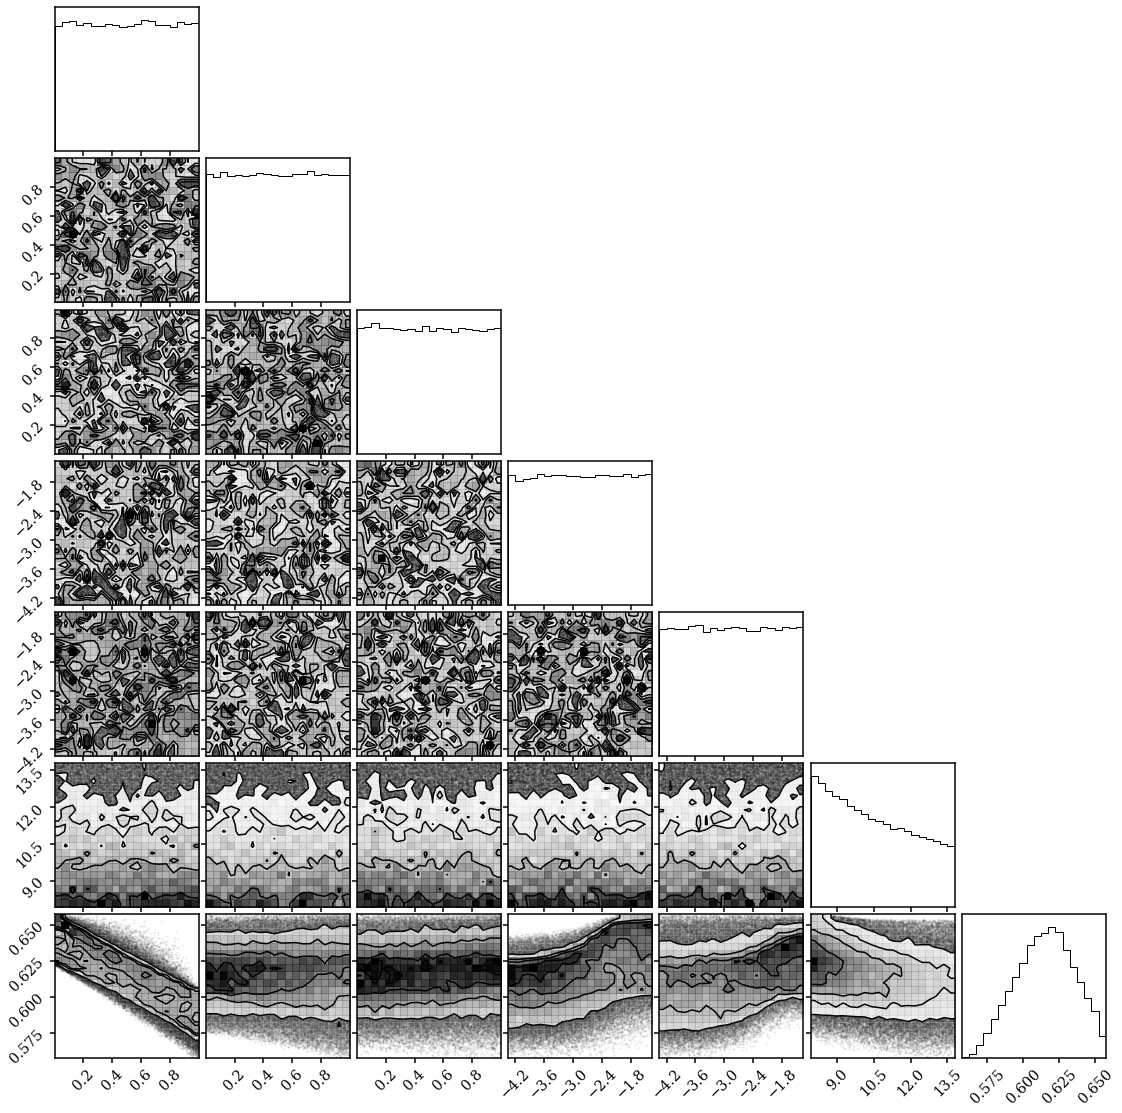

In [7]:
_ = DFM.corner(np.concatenate([thetas, msurv[:,None]], axis=1))

In [8]:
theta_shift = np.mean(thetas, axis=0)
theta_scale = np.std(thetas, axis=0)

_thetas = (thetas - theta_shift) / theta_scale

msurv_shift = np.mean(msurv, axis=0)
msurv_scale = np.std(msurv, axis=0)

_msurvs = (msurv - msurv_shift) / msurv_scale

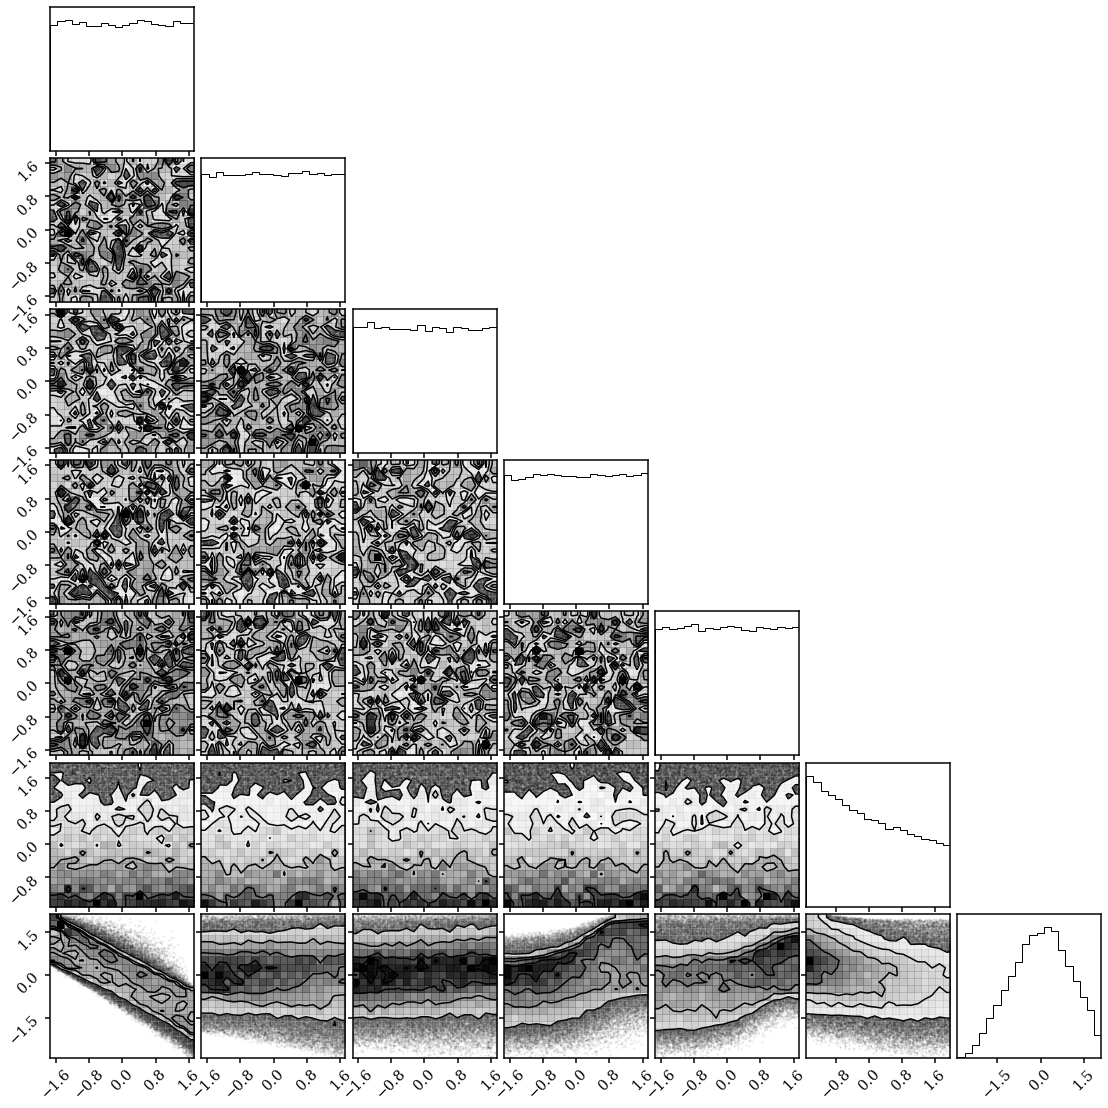

In [9]:
_ = DFM.corner(np.concatenate([_thetas, _msurvs[:,None]], axis=1))

In [10]:
torch.autograd.set_detect_anomaly(True)

In [11]:
Ntrain = int(0.9 * _thetas.shape[0])
Nvalid = _thetas.shape[0] - Ntrain
print('Ntrain = %i' % Ntrain)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    torch.from_numpy(_thetas[:Ntrain,:].astype(np.float32)), 
    torch.from_numpy(_msurvs[:Ntrain,None].astype(np.float32))), batch_size=512, shuffle=True)

valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    torch.from_numpy(_thetas[Ntrain:,:].astype(np.float32)), 
    torch.from_numpy(_msurvs[Ntrain:,None].astype(np.float32))), batch_size=512, shuffle=True)

Ntrain = 90000


In [16]:
lrate = 1e-3
epochs = int(1e4)
patience = 20 

mlp = MLP(thetas.shape[1], 1, n_hidden=[128, 128, 128, 128, 128])
mlp.to(device)

optimizer = optim.Adam(mlp.parameters(), lr=lrate, weight_decay=0)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lrate, epochs=epochs, steps_per_epoch=len(train_loader))

  0%|          | 0/10000 [00:00<?, ?it/s]

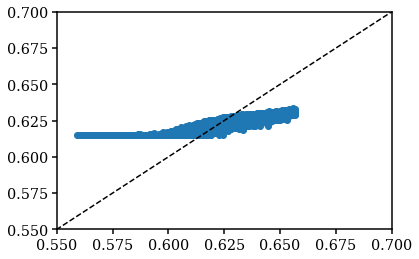

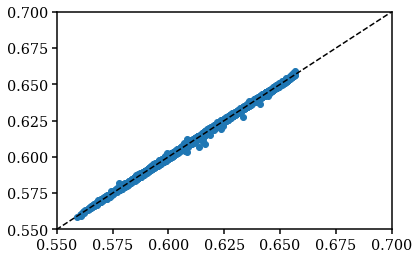

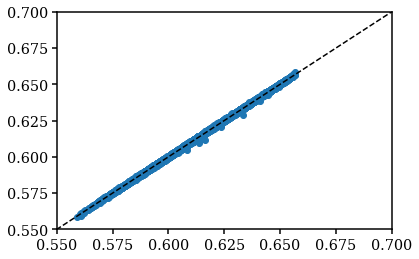

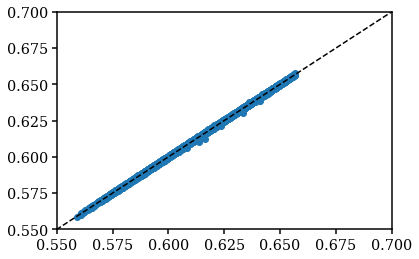

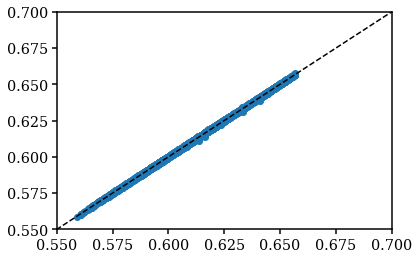

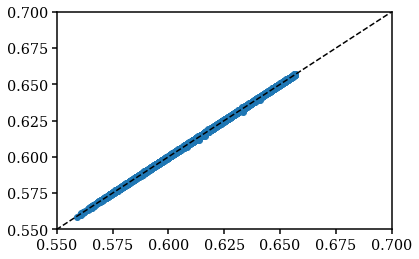

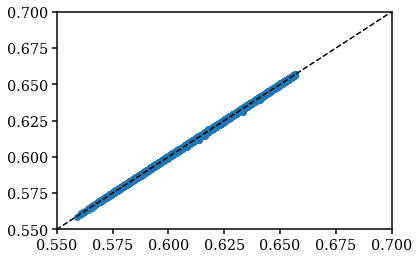

Stopping
====> Epoch: 618 TRAINING Loss: 7.54e-05 VALIDATION Loss: 8.66e-05


In [17]:
best_epoch = 0
best_valid_loss = np.inf
train_losses, valid_losses = [], []

t = trange(epochs, leave=False)
for epoch in t:
    mlp.train()
    train_loss = 0
    for batch in train_loader:
        _x, _y = batch
        _x = _x.to(device)
        _y = _y.to(device)
        optimizer.zero_grad()

        #loss = torch.sqrt(torch.sum(torch.pow(_y - mlp.forward(_x), 2), dim=-1))
        loss = F.mse_loss(_y, mlp.forward(_x))#torch.mean(loss)
        loss.backward()
        train_loss += loss.item()
        
        torch.nn.utils.clip_grad_norm_(mlp.parameters(), 1)
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    with torch.no_grad():
        valid_loss = 0
        for val_batch in valid_loader:
            x_val, y_val = val_batch
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            #_loss = torch.sqrt(torch.sum((y_val - mlp.forward(x_val))**2, dim=-1))
            _loss = F.mse_loss(y_val, mlp.forward(x_val))#torch.mean(_loss)
            valid_loss += _loss.item()
        valid_loss /= len(valid_loader)
        if np.isnan(valid_loss): raise ValueError
        valid_losses.append(valid_loss)

    scheduler.step()

    t.set_description('Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % (epoch, train_loss, valid_loss), refresh=False)
    
    if epoch % 100 == 0: 
        with torch.no_grad(): 
            _msurv_pred = mlp.forward(torch.tensor(_thetas[Ntrain:].astype(np.float32)).to(device)).cpu().numpy()* msurv_scale + msurv_shift

        plt.scatter(_msurvs[Ntrain:] * msurv_scale + msurv_shift, _msurv_pred)
        plt.plot([0., 1.], [0., 1.], c='k', ls='--')
        plt.xlim(0.55, 0.7)
        plt.ylim(0.55, 0.7)
        plt.show()
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        best_model = copy.deepcopy(mlp)
        
    else:
        if epoch > best_epoch + patience:
            print('Stopping')
            print('====> Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % (epoch, train_loss, best_valid_loss))
            break

(0.0, 619.0)

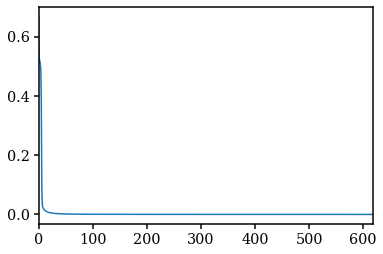

In [18]:
plt.plot(valid_losses)
plt.xlim(0, len(valid_losses))

In [19]:
#torch.save(best_model, os.path.join(dat_dir, 'emu_msurv.nmf.0.pt')) # valid loss = 1.58e-4
torch.save(best_model, os.path.join(dat_dir, 'emu_msurv.nmf.1.pt')) # valid loss = 8.66e-5

In [22]:
np.save(os.path.join(dat_dir, 'thetas_shift.npy'), theta_shift)
np.save(os.path.join(dat_dir, 'thetas_scale.npy'), theta_scale)

In [21]:
np.save(os.path.join(dat_dir, 'msurv_nmf_shift.npy'), msurv_shift)
np.save(os.path.join(dat_dir, 'msurv_nmf_scale.npy'), msurv_scale)